# 深度卷积生成对抗网络

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.2.0'

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## 加载准备数据集

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5       # 将图片标准化到[-1, 1]区间内

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
# 批量化和打乱数据
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 创建模型

### 生成器
从上采样层来种子（随机噪声）中产生图片

In [8]:
def make_genrator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7,7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False,activation="tanh"))
    assert model.output_shape == (None, 28, 28, 1)

    return model

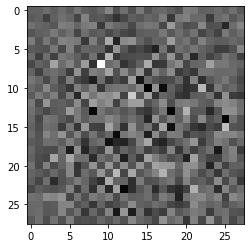

In [9]:
# 使用未经训练的生成器创建一张图片
generator = make_genrator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gray")

### 判别器
基于CNN的图片分类器

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
# 使用未经训练的判别器来对图片的真伪进行判断。真实图片输出正值，伪造图片输出负值
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00119956]], shape=(1, 1), dtype=float32)


## 定义损失函数和优化器

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 判别器损失
量化判别器判断真伪图片的能力

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 生成器损失
生成器损失量化其欺骗判别器的能力

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
# 优化器
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

In [17]:
## 定义训练循环
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### 生成与保存图片

In [19]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")

    plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

In [20]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # 继续进行时为GIF生成图像
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)

        # 每15个epoch保存一次模型
        if(epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print("time for epoch {} is {} sec".format(epoch+1, time.time()-start))

    # 最后一个epoch结束后生成图片
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

## 训练模型

In [23]:
%%time
train(train_dataset, EPOCHS)

ValueError: Creating variables on a non-first call to a function decorated with tf.function.